# Bulls - Stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 11 # Bulls
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(33446, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33446 entries, 0 to 33445
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            33446 non-null  int64  
 1   dimCustomerMasterId     33446 non-null  int64  
 2   customerNumber          33446 non-null  object 
 3   year                    33446 non-null  int64  
 4   productGrouping         33446 non-null  object 
 5   totalSpent              33446 non-null  float64
 6   recentDate              33446 non-null  object 
 7   attendancePercent       33446 non-null  float64
 8   renewedBeforeDays       33444 non-null  float64
 9   isBuyer                 33446 non-null  object 
 10  source_tenure           33446 non-null  int64  
 11  tenure                  33444 non-null  float64
 12  distToVenue             33446 non-null  float64
 13  totalGames              33446 non-null  int64  
 14  recency                 33446 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (25641, 13)
Unseen Data For Predictions: (4525, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7959,0.8386,0.5772,0.7182,0.6398,0.4998,0.5057,0.6660
lr,Logistic Regression,0.7508,0.7744,0.4543,0.6475,0.5338,0.3708,0.3818,0.5200


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7894,0.8209,0.5547,0.7116,0.6235,0.4804,0.4876
1,0.8073,0.8513,0.6161,0.7288,0.6677,0.5334,0.5371
2,0.7982,0.8345,0.5679,0.7298,0.6388,0.5017,0.5093
3,0.7963,0.8380,0.5664,0.7252,0.6361,0.4976,0.5049
4,0.7843,0.8275,0.5752,0.6876,0.6264,0.4765,0.4802
5,0.7843,0.8417,0.5591,0.6951,0.6197,0.4717,0.4771
6,0.7972,0.8497,0.6029,0.7084,0.6514,0.5097,0.5130
7,0.7976,0.8263,0.5606,0.7328,0.6352,0.4986,0.5072
8,0.8105,0.8557,0.6102,0.7411,0.6693,0.5382,0.5432
9,0.7935,0.8402,0.5591,0.7213,0.6299,0.4899,0.4975


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(3265, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
30181,11,319733198,27843,2021,Full Season,7142.4,2021-09-26,0.288679,78.0,TRUE,...,0,0,0.0,1,132,0,1,1,0.2332,0.7668
30182,11,319736768,30886,2021,Half Season,1134.0,2021-08-18,0.201923,14.0,TRUE,...,0,0,0.0,1,132,0,0,1,0.4806,0.5194
30183,11,319737266,414575,2021,Mini Plan,126.0,2021-09-23,0.833333,104.0,TRUE,...,0,0,0.0,1,132,0,0,0,0.6430,0.3570
30184,11,319738155,199434,2021,Full Season,1500.2,2021-09-12,0.423077,99.0,TRUE,...,0,0,0.0,1,132,0,1,0,0.8217,0.1783
30185,11,319738216,24993,2021,Mini Plan,144.0,2021-09-09,0.833333,101.0,TRUE,...,0,0,0.0,1,132,0,1,1,0.2008,0.7992


In [11]:
new_predictions["Label"].value_counts()

0    2764
1     501
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1831
(0.2, 0.4]        704
(0.4, 0.6]        415
(0.6, 0.8]        273
(0.8, 1.0]         42
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

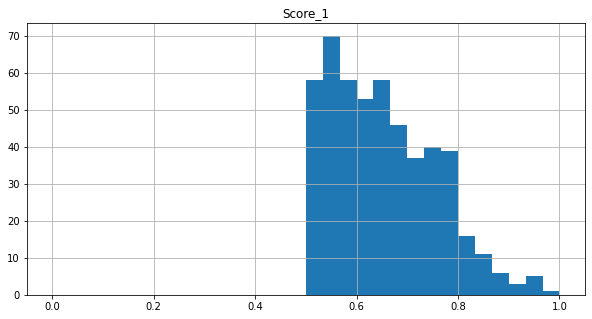

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

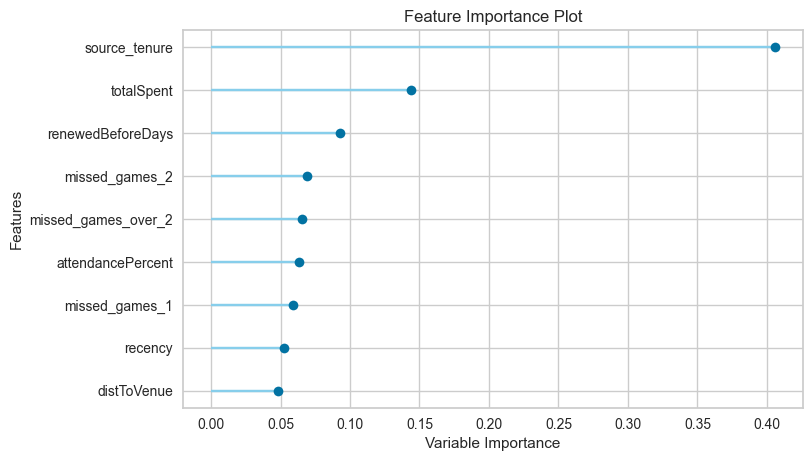

In [14]:
plot_model(best_model, plot='feature')

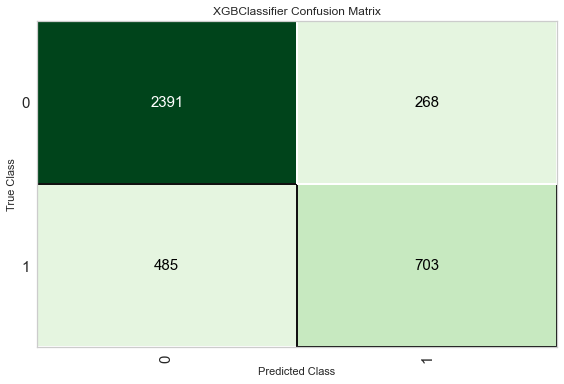

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?